In [1]:
#import needed packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import sklearn as sk
import scipy.io as sio

In [2]:
#Function Section

def gaussian_kernel(x1, x2, h):
    x1 = x1.reshape(-1, 1)
    x2 = x2.reshape(-1, 1)
    return np.exp(-0.5 * ((x1 - x2) / h)**2) / np.sqrt(2 * np.pi)

def kde(x, X, h):
    n = len(X)
    distances = cdist(np.array([x]).reshape(1, -1), X.reshape(1, -1), metric='euclidean')
    kernel_values = np.exp(-0.5 * (distances / h)**2) / np.sqrt(2 * np.pi)
    return np.sum(kernel_values) / (n * h)

def leave_one_out_cross_validation(X, h_values):
    n = len(X)
    cv_scores = []
    for h in h_values:
        score_sum = 0
        for i in range(n):
            X_temp = X.copy()
            X_temp[i] = 0
            f_hat_i = kde(X[i], X_temp[X_temp != 0], h)
            score_sum += (f_hat_i - 1/(n-1))**2
        cv_scores.append(score_sum)
    return h_values[np.argmin(cv_scores)]


In [3]:
#load data from matrix file, anomaly

dataset = sio.loadmat('Data/anomaly.mat')
X = dataset['X'][0]
xtest1 = dataset['xtest1'][0][0]
xtest2 = dataset['xtest2'][0][0]


#from this file we have the X value, but we need to find the density function f

print(f'xtest point1: {xtest1}')
print(f'xtest point2: {xtest2}')

xtest point1: 2.85
xtest point2: -1.5


In [4]:
#Part A) Selecting the bandwidth parameters, use a grid search method to test multiple values

def gaussian_kernel(x1, x2, h):
    return np.exp(-0.5 * ((x1 - x2) / h)**2) / np.sqrt(2 * np.pi)

def kde(x, X, h):
    n = len(X)
    kernel_values = [gaussian_kernel(x, xi, h) for xi in X]
    return np.sum(kernel_values) / (n * h)

def leave_one_out_estimator(X, h_values):
    n = len(X)
    best_bandwidth = None
    min_cv_error = float('inf')
    for h in h_values:
        cv_error_sum = 0
        for i in range(n):
            X_temp = np.delete(X, i)  # Remove one point from X
            f_hat_minus_i = kde(X[i], X_temp, h)
            if n - 1 == 0:  # Check if (n - 1) is zero
                cv_error_sum += f_hat_minus_i**2  # Handle division by zero by using f_hat_minus_i directly
            else:
                cv_error_sum += (f_hat_minus_i - 1 / (n - 1))**2
        cv_error = cv_error_sum / n
        if cv_error < min_cv_error:
            min_cv_error = cv_error
            best_bandwidth = h
    return best_bandwidth

# Define the range of bandwidth values to search
h_values = np.linspace(0.01, 2, 100)

# Perform leave-one-out cross-validation for bandwidth selection
selected_bandwidth = leave_one_out_estimator(X, h_values)
print("Selected Bandwidth:", selected_bandwidth)

Selected Bandwidth: 2.0


Selected Bandwidth: 2.0


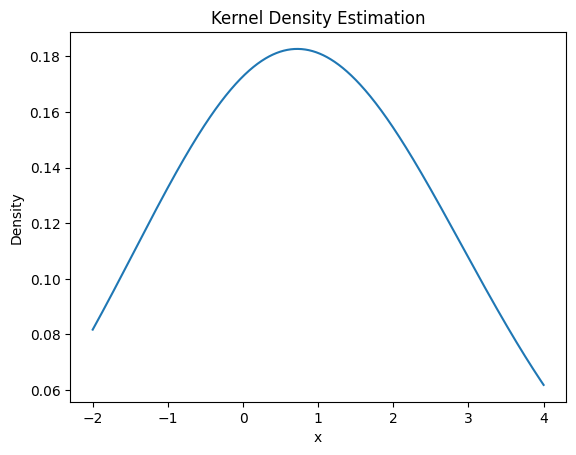

OutlierScore1 for xtest1: 0.6791207476361262
OutlierScore1 for xtest2: 0.6327715596307217
OutlierScore2 for xtest1 (k=100): 0.018523916095922324
OutlierScore2 for xtest2 (k=100): 0.007534715893921999
OutlierScore2 for xtest1 (k=150): 0.007166457490454417
OutlierScore2 for xtest2 (k=150): 0.00458343780227506
OutlierScore2 for xtest1 (k=200): 0.004162266080302847
OutlierScore2 for xtest2 (k=200): 0.003215366931836176
OutlierScore2 for xtest1 (k=500): 0.0009750428448191151
OutlierScore2 for xtest2 (k=500): 0.0008695529929771248


In [6]:
import numpy as np
import scipy.io

# Load data
data = scipy.io.loadmat('Data/anomaly.mat')
X = data['X'].flatten()
xtest1 = data['xtest1'][0][0]
xtest2 = data['xtest2'][0][0]

# (a) Bandwidth selection
def gaussian_kernel(x1, x2, h):
    return np.exp(-0.5 * ((x1 - x2) / h)**2) / np.sqrt(2 * np.pi)

def kde(x, X, h):
    n = len(X)
    kernel_values = gaussian_kernel(x, X, h)
    return np.sum(kernel_values) / (n * h)

def leave_one_out_cross_validation(X, h_values):
    n = len(X)
    cv_scores = []
    for h in h_values:
        score_sum = 0
        for i in range(n):
            X_temp = X.copy()
            X_temp[i] = 0
            f_hat_i = kde(X[i], X_temp[X_temp != 0], h)
            score_sum += (f_hat_i - 1/(n-1))**2
        cv_scores.append(score_sum)
    return h_values[np.argmin(cv_scores)]

# Bandwidth selection
h_values = np.linspace(0.01, 20, 100)

def grid_search_bandwidth(X, h_values):
    best_bandwidth = None
    best_score = float('inf')  # Initialize best score to a large value
    for h in h_values:
        score_sum = 0
        for i in range(len(X)):
            X_temp = X.copy()
            X_temp[i] = 0
            f_hat_i = kde(X[i], X_temp[X_temp != 0], h)
            score_sum += (f_hat_i - 1 / (len(X) - 1)) ** 2
        score = score_sum / len(X)
        if score < best_score:
            best_score = score
            best_bandwidth = h
    return best_bandwidth

# Define the range of bandwidth values to search
h_values = np.linspace(0.01, 2, 100)

selected_bandwidth = grid_search_bandwidth(X,h_values)

#selected_bandwidth = leave_one_out_cross_validation(X, h_values)
print("Selected Bandwidth:", selected_bandwidth)

# (b) KDE estimation and plotting
x_values = np.linspace(-2, 4, 1000)
kde_values = [kde(x, X, selected_bandwidth) for x in x_values]
plt.plot(x_values, kde_values)
plt.title('Kernel Density Estimation')
plt.xlabel('x')
plt.ylabel('Density')
plt.show()

# Based on the KDE, the true density f appears to be unimodal and skewed to the right.

# (c) OutlierScore1 conceptual interpretation
# OutlierScore1 measures the relative density at a point compared to its neighboring points.
# If the score is low, it indicates that the point has lower density compared to its neighbors, potentially making it an outlier.
# Conversely, a high score suggests that the point's density is similar to its neighbors, making it less likely to be an outlier.

# (d) Calculate OutlierScore1 for xtest1 and xtest2
def outlier_score_1(x, X, h):
    n = len(X)
    f_hat_x = kde(x, X, h)
    neighbor_sum = np.sum([kde(X[i], X, h) for i in range(n)]) - f_hat_x
    return n * f_hat_x / neighbor_sum

outlier_score_xtest1 = outlier_score_1(xtest1, X, selected_bandwidth)
outlier_score_xtest2 = outlier_score_1(xtest2, X, selected_bandwidth)
print("OutlierScore1 for xtest1:", outlier_score_xtest1)
print("OutlierScore1 for xtest2:", outlier_score_xtest2)

# (e) OutlierScore2 conceptual interpretation
# OutlierScore2 is based on the average distance to the k-nearest neighbors.
# If a point has a low score, it means it is closer to its neighbors, suggesting it's not an outlier.
# Conversely, a high score indicates that the point is farther away from its neighbors, potentially making it an outlier.
# This score is related to k-nn density estimation as it also considers the local density of points.

# (f) Calculate OutlierScore2 for xtest1 and xtest2 using different values of k
def outlier_score_2(x, X, k):
    distances = np.abs(X - x)
    sorted_indices = np.argsort(distances)
    k_nearest_distances = distances[sorted_indices[:k]]
    return 1 / (k * np.mean(k_nearest_distances))

k_values = [100, 150, 200,500]
for k in k_values:
    outlier_score_xtest1_2 = outlier_score_2(xtest1, X, k)
    outlier_score_xtest2_2 = outlier_score_2(xtest2, X, k)
    print(f"OutlierScore2 for xtest1 (k={k}):", outlier_score_xtest1_2)
    print(f"OutlierScore2 for xtest2 (k={k}):", outlier_score_xtest2_2)
